<p style="font-size: 20px;">
    The dataset contains records of smartphone sale posts over a span of two months on Divar. This platform facilitates direct interactions between sellers and buyers, allowing individuals to list and trade smartphones and other items. The dataset includes detailed information on various aspects of the posts, such as the condition of the phones, brand authenticity, storage capacity, RAM, and pricing, among other attributes.
</p>

<p style="font-size: 20px;">
    The goal of this notebook is to develop a predictive model capable of accurately estimating the price of smartphones based on the provided dataset. By analyzing various features such as the condition of the phone, brand authenticity, storage capacity, RAM, and other relevant attributes, the model aims to uncover patterns and relationships that influence pricing.
</p>

# installing libraries

#### jdatetimes for handling jalali dates

In [1]:
!pip install jdatetime


#### Arabic reshaper for farsi texts

In [2]:
!pip install arabic-reshaper

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import OrdinalEncoder , LabelEncoder , OneHotEncoder , MinMaxScaler , StandardScaler
from sklearn.ensemble import GradientBoostingRegressor , RandomForestRegressor , VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import jdatetime
import re
import arabic_reshaper
from bidi.algorithm import get_display

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iran-phone-ads/final.csv


In [4]:
data = pd.read_csv('/kaggle/input/iran-phone-ads/final.csv')

# Functions

In [5]:
def separate_fa_and_eng(df, column_name):
    ''' function for color column'''
    eng_pattern = re.compile(r'[A-Za-z]+')  # + to capture full words
    farsi_pattern = re.compile(r'[\u0600-\u06FF]+')  # + to capture full words
    
    df[column_name + '_fa'] = None
    df[column_name + '_eng'] = None
    
    
    for index, row in df.iterrows():    # Iterate over DataFrame
        text = row[column_name]
        if pd.isna(text):
            df.at[index, column_name + '_fa'] = pd.NA
            df.at[index, column_name + '_eng'] = pd.NA
        elif isinstance(text, str) and text.lower() == "unknown":
            df.at[index, column_name + '_fa'] = "unknown"
            df.at[index, column_name + '_eng'] = "unknown"
        else:
            # Check for content
            if eng_pattern.search(text) and farsi_pattern.search(text):
                # Extract parts
                eng_part = " ".join(eng_pattern.findall(text))
                farsi_part = " ".join(farsi_pattern.findall(text))
                df.at[index, column_name + '_eng'] = eng_part
                df.at[index, column_name + '_fa'] = farsi_part
            elif eng_pattern.search(text):
                df.at[index, column_name + '_eng'] = text
            elif farsi_pattern.search(text):
                df.at[index, column_name + '_fa'] = text
                
                

def extract_primary_color(x):
    if pd.notnull(x):
        return x.split()[0]
    else:
        return None
    

def translate_farsi_to_english(value):
    translation_dict = {
        'کارکرده': 'used',
        'در حد نو': 'as good as new',
        'نو':'new',
        'نیاز به تعمیر':'repair needed',
        'اصل':'orginal',
        'غیر اصل':'fake',
        'نیستم':'no',
        'هستم':'yes'
        }
    return translation_dict.get(value, value)



def transform_date_to_gregorian(date_str):
    year, month, day = map(int, date_str.split('/'))
    solar_hijri_date = jdatetime.date(year, month, day)
    gregorian_date = solar_hijri_date.togregorian()
    return gregorian_date


def transform_units(value):
    if pd.isna(value):
        return np.nan
    if 'گیگابایت' in value:
        return value.replace('گیگابایت', 'GB').strip()
    elif 'مگابایت' in value:
        return value.replace('مگابایت', 'MB').strip()
    elif 'ترابایت' in value:
        return value.replace('ترابایت', 'TB').strip()
    elif 'مطرح نیست' in value:
        return 'Not Relevant'
    else:
        return value
    
    

def convert_numeric_persian_to_english(value):
    '''Function to convert Persian numerals to English numeral'''
    if pd.isna(value):
        return np.nan
    for persian_num, english_num in persian_to_english.items():
        value = value.replace(persian_num, english_num)
    return value



def transform_num_of_sim(value):
    if pd.isna(value):
        return np.nan
    
    if '۳ و بیشتر' in value:
        return '3'
    
    for persian_num, english_num in persian_to_english.items():
        value = value.replace(persian_num, english_num)
    
    value = value.replace('عدد', '').strip()
    return value



def plot_pie_charts(df, columns, figsize=(8, 8), title_suffix=''):
    """
    Plots pie charts for multiple categorical columns from a pandas DataFrame with Seaborn styles.
    """
    sns.set_theme(style="whitegrid")
    for column in columns:
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in DataFrame.")
        col_data = df[column].value_counts()  # Calculate count
        plt.figure(figsize=figsize)
        plt.pie(col_data, labels=col_data.index, autopct='%1.1f%%', startangle=140)
        plt.axis('equal')
        title = f"Distribution of {column} {title_suffix}".strip() # Set title
        plt.title(title)
        plt.show()
        
        

def plot_count(df, columns , hue=None):
    """
    Plots bar charts for specified categorical columns from a DataFrame, sorted by frequency.
    """
    if isinstance(columns, str): # Ensure it's a list
        columns = [columns]
    
    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
        
        order = df[col].value_counts().index # Sort Values
        
        # Plotting
        plt.figure(figsize=(10, 5))
        sns.countplot(x=col, data=df, palette='viridis', order=order , hue=hue)
        plt.title(f'Distribution of {col} (sorted by frequency)')
        plt.xticks(rotation=90)
        plt.xlabel(col)
        plt.ylabel('Counts')
        plt.show()
        
        

def transform_to_gb(df, column):
    df[column + '_in_GB'] = df[column].apply(lambda value: 
        float(value.split()[0]) * 1024 if isinstance(value, str) and 'TB' in value
        else (float(value.split()[0]) if isinstance(value, str) and 'GB' in value
        else (float(value.split()[0]) / 1024 if isinstance(value, str) and 'MB' in value
        else None if pd.isnull(value) else None)))
    return df



def modify_model_column(value):
    if isinstance(value, str):
        value = value.replace('سامسونگ', '').replace('شیائومی', '')
        
        if 'تی ای' in value or 'اریکسون' in value or 'پلاس' in value:
            return np.nan
        else:
            return value.strip()  # remove whitespace
    else:
        # If value is not a string, return it as is
        return value
    
    
    
def categorize_price(price):
    pass



def clean_model_names(model_list):
    cleaned_list = []
    for model in model_list:
        # Check String
        if isinstance(model, str):
            model = model.lower()
            
            model = model.replace("-", " ").replace("(", "").replace(")", "")
            
            # Remove years between 2012 and 2024
            model = re.sub(r'\b(201[2-9]|202[0-4])\b', '', model)
            
            model = model.strip()
        else:
            model = "unknown" 

        cleaned_list.append(model)

    return cleaned_list
    


## Dictionaries

In [6]:
persian_to_english = {
    '۰': '0',
    '۱': '1',
    '۲': '2',
    '۳': '3',
    '۴': '4',
    '۵': '5',
    '۶': '6',
    '۷': '7',
    '۸': '8',
    '۹': '9'
}


color_translation = {
    'مشکی': 'black',
    'آبی': 'blue',
    'طلایی': 'gold',
    'سفید': 'white',
    'خاکستری': 'grey',
    'نقره‌ای': 'silver',
    'سبز': 'green',
    'بنفش': 'purple',
    'قرمز': 'red',
    'صورتی': 'pink',
    'زرد': 'yellow',
    'لیمویی': 'lime',
    'قهوه‌ای': 'brown',
    'نارنجی': 'orange',
    'unknown': 'unknown'
}

# Understanding Dataset

In [7]:
data.head()

,title,city,condition,brand authenticity,willing to trade,number of SIM cards,internal storage,RAM size,color,brand,model,price,fixed_price,date,neighborhood
0,گوشی a02s,aalasht,کارکرده,اصل,نیستم,NaN,NaN,NaN,NaN,samsung,NaN,2800000,No,1403/02/18,مرزیکلا
1,سامسونگ گلکسی A72 5G ۲۵۶ گیگابایت,aalasht,در حد نو,اصل,نیستم,۲ عدد,۲۵۶ گیگابایت,۸ گیگابایت,مشکی Awesome,samsung,galaxy-a72-5g,11200000,No,1403/02/25,فیروزکوه
2,آنر۷ x,aalasht,کارکرده,اصل,نیستم,۲ عدد,۳۲ گیگابایت,۴ گیگابایت,خاکستری,honor,7x,2300000,No,1403/03/10,شیرگاه
3,سامسونگ Galaxy J1 mini prime ۸ گیگابایت,aalasht,کارکرده,اصل,نیستم,۲ عدد,۸ گیگابایت,۱ گیگابایت,سفید,samsung,galaxy-j1-mini-prime,1250000,Yes,1403/02/25,فیروزکوه
4,ایفون x سالم,aalasht,در حد نو,اصل,نیستم,۱ عدد,۶۴ گیگابایت,۳ گیگابایت,خاکستری Space,apple,iPhone X,13000000,Yes,1403/02/25,مرزیکلا


In [8]:
data.rename(columns={ 'brand authenticity':'brand_authenticity' , 'willing to trade' : 'willing_to_trade' , 'number of SIM cards':'num_of_sim' ,
                    'internal storage' : 'storage' , 'RAM size':'ram'} , inplace=True   )
data.columns

Index(['title', 'city', 'condition', 'brand_authenticity', 'willing_to_trade',
       'num_of_sim', 'storage', 'ram', 'color', 'brand', 'model', 'price',
       'fixed_price', 'date', 'neighborhood'],
      dtype='object')

<!DOCTYPE html>
<html>
<head>
    <style>
        table {
            font-size: 16px;
            border-collapse: collapse;
            width: 100%;
        }
        th, td {
            border: 1px solid black;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
</head>
<body>
    <table>
        <tr>
            <th>Column Name</th>
            <th>Description</th>
        </tr>
        <tr>
            <td>title</td>
            <td>The title of the post.</td>
        </tr>
        <tr>
            <td>city</td>
            <td>The city where the phone was posted.</td>
        </tr>
        <tr>
            <td>condition</td>
            <td>The condition of the phone (e.g., new, used).</td>
        </tr>
        <tr>
            <td>brand_authenticity</td>
            <td>Indicates whether the brand of the phone is authentic or not.</td>
        </tr>
        <tr>
            <td>willing_to_trade</td>
            <td>Indicates if the seller is willing to trade the phone for another item.</td>
        </tr>
        <tr>
            <td>num_of_sim</td>
            <td>The number of SIM card slots in the phone.</td>
        </tr>
        <tr>
            <td>storage</td>
            <td>storage capacity of the phone.</td>
        </tr>
        <tr>
            <td>ram</td>
            <td>RAM capacity of the phone.</td>
        </tr>
        <tr>
            <td>color</td>
            <td>color of the phone.</td>
        </tr>
        <tr>
            <td>brand</td>
            <td>brand of the phone.</td>
        </tr>
        <tr>
            <td>model</td>
            <td>model of the phone.</td>
        </tr>
        <tr>
            <td>price</td>
            <td>price of the phone.</td>
        </tr>
        <tr>
            <td>fixed_price</td>
            <td>Indicates if the price is fixed or negotiable.</td>
        </tr>
        <tr>
            <td>date</td>
            <td>The date when the post was posted.</td>
        </tr>
        <tr>
            <td>neighborhood</td>
            <td>The neighborhood where the phone is being posted.</td>
        </tr>
    </table>
</body>
</html>

In [9]:
data.shape , data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91466 entries, 0 to 91465
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               91466 non-null  object
 1   city                91466 non-null  object
 2   condition           91466 non-null  object
 3   brand_authenticity  91463 non-null  object
 4   willing_to_trade    84084 non-null  object
 5   num_of_sim          85510 non-null  object
 6   storage             80066 non-null  object
 7   ram                 80872 non-null  object
 8   color               73288 non-null  object
 9   brand               89316 non-null  object
 10  model               79553 non-null  object
 11  price               91465 non-null  object
 12  fixed_price         91466 non-null  object
 13  date                91466 non-null  object
 14  neighborhood        91466 non-null  object
dtypes: object(15)
memory usage: 10.5+ MB


((91466, 15), None)

In [10]:
data.isnull().sum()

title                     0
city                      0
condition                 0
brand_authenticity        3
willing_to_trade       7382
num_of_sim             5956
storage               11400
ram                   10594
color                 18178
brand                  2150
model                 11913
price                     1
fixed_price               0
date                      0
neighborhood              0
dtype: int64

In [11]:
data.describe().T

,count,unique,top,freq
title,91466,33970,اپل iPhone 13 ۱۲۸ گیگابایت,1126
city,91466,341,tehran,17087
condition,91466,4,در حد نو,54606
brand_authenticity,91463,2,اصل,89615
willing_to_trade,84084,2,نیستم,70378
num_of_sim,85510,3,۲ عدد,66633
storage,80066,16,۱۲۸ گیگابایت,24628
ram,80872,14,۴ گیگابایت,20786
color,73288,538,مشکی,17814
brand,89316,49,samsung,28725


In [12]:
data.duplicated().sum() 

202

In [13]:
data.drop_duplicates(inplace=True)

In [14]:
data.nunique()

title                 33970
city                    341
condition                 4
brand_authenticity        2
willing_to_trade          2
num_of_sim                3
storage                  16
ram                      14
color                   538
brand                    49
model                  1792
price                  2325
fixed_price               2
date                     68
neighborhood           1271
dtype: int64

# Change object data types

In [15]:
data['price'] = data['price'].replace('توافقی', np.nan)
data['price'] = pd.to_numeric(data['price'], errors='coerce')

In [16]:
data['Shamsi_datetime'] = data['date'].apply(lambda x: jdatetime.date(*map(int, x.split('/'))))
data['gregorian_datetime'] = data['date'].apply(transform_date_to_gregorian)
data['gregorian_datetime'] = pd.to_datetime(data['gregorian_datetime'])
data.drop(columns= 'date' , axis=1 , inplace=True)
# clean this

In [17]:
data['storage'] = data['storage'].apply(lambda x: convert_numeric_persian_to_english(transform_units(x)))

In [18]:
data['ram'] = data['ram'].apply(lambda x: convert_numeric_persian_to_english(transform_units(x)))

In [19]:
data['num_of_sim'] = data['num_of_sim'].apply(transform_num_of_sim)

In [20]:
data[['brand_authenticity', 'condition', 'willing_to_trade']] = data[['brand_authenticity', 'condition', 'willing_to_trade']].applymap(translate_farsi_to_english)

/tmp/ipykernel_18/2184991199.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[['brand_authenticity', 'condition', 'willing_to_trade']] = data[['brand_authenticity', 'condition', 'willing_to_trade']].applymap(translate_farsi_to_english)


# Putting unknown for visualization

In [21]:
data.dropna(subset=['brand_authenticity'] , inplace=True)
data.dropna(subset=['price'] , inplace=True)

In [22]:
data_visual = data.copy()

In [23]:
data_visual['willing_to_trade'] = data_visual['willing_to_trade'].fillna('unknown') #keep
data_visual['color'] = data_visual['color'].fillna('unknown') #keep
data_visual['storage'] = data_visual['storage'].fillna('unknown') #keep
data_visual['num_of_sim'] = data_visual['num_of_sim'].fillna('unknown') #use KNN
data_visual['ram'] = data_visual['ram'].fillna('unknown') # use KNN
data_visual['brand'] = data_visual['brand'].fillna('unknown') # use KNN
data_visual['model'] = data_visual['model'].fillna('unknown') # use KNN

# Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


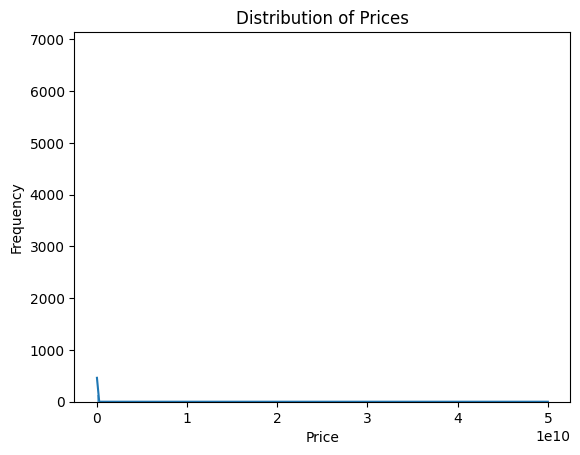

In [24]:
sns.histplot(data_visual['price'], kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

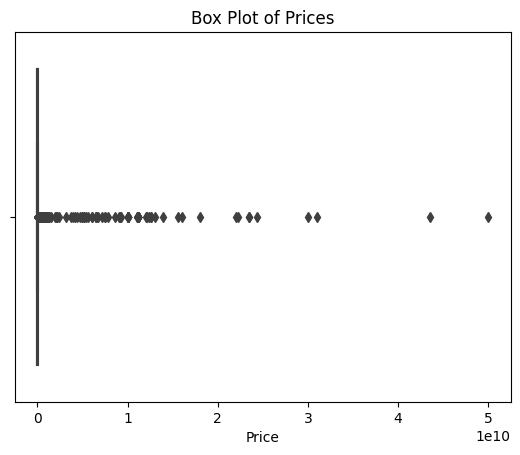

In [25]:
sns.boxplot(x=data_visual['price'])
plt.title('Box Plot of Prices')
plt.xlabel('Price')
plt.show()

In [26]:
data['price_in_millions'] = data['price'] / 1000000
data = data[(data['price_in_millions'] < 70) & (data['price_in_millions'] > 0.5)]
data_visual['price_in_millions'] = data_visual['price'] / 1000000
data_visual = data_visual[(data_visual['price_in_millions'] < 70) & (data_visual['price_in_millions'] > 0.5)]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


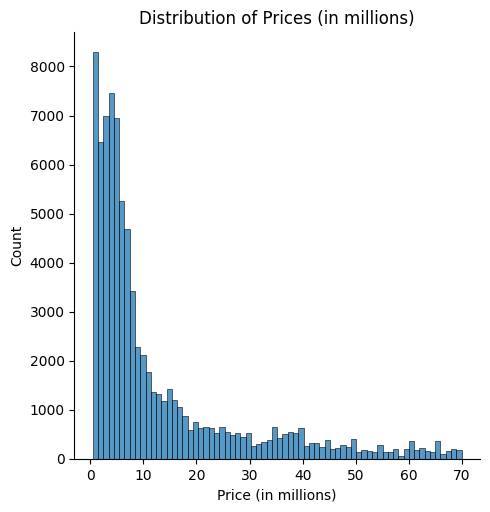

In [27]:
sns.displot(data['price_in_millions'], bins=70, kde=False)
plt.xlabel('Price (in millions)')
plt.ylabel('Count')
plt.title('Distribution of Prices (in millions)')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


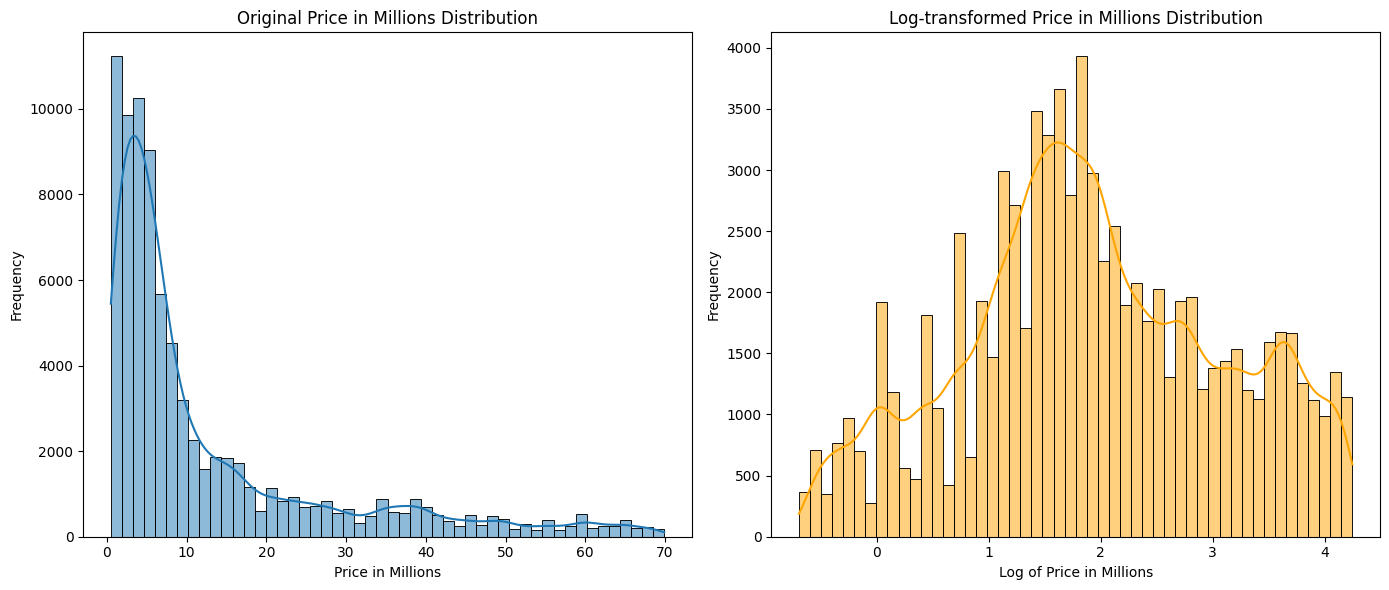

In [28]:
data = data[data['price_in_millions'] > 0]

data['log_price_in_millions'] = np.log(data['price_in_millions'])


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['price_in_millions'], bins=50, kde=True)
plt.title('Original Price in Millions Distribution')
plt.xlabel('Price in Millions')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data['log_price_in_millions'], bins=50, kde=True, color='orange')
plt.title('Log-transformed Price in Millions Distribution')
plt.xlabel('Log of Price in Millions')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


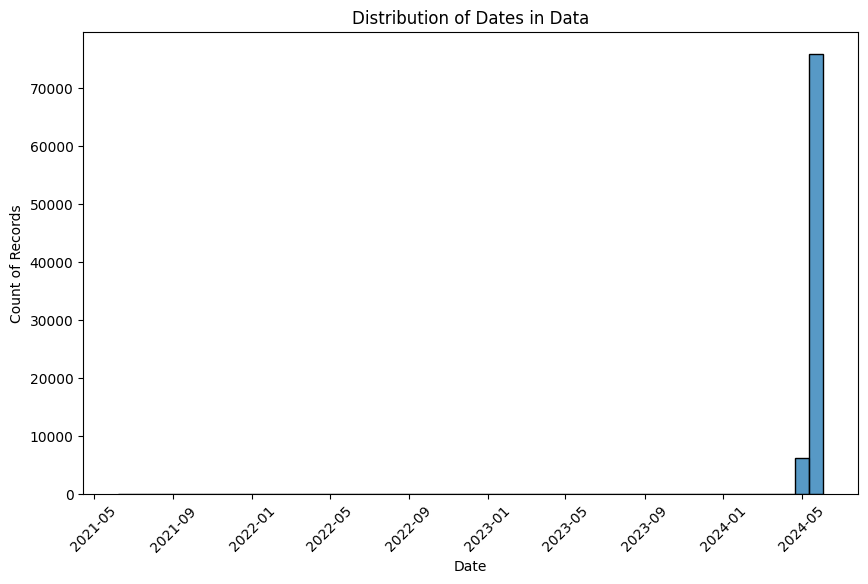

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data_visual['gregorian_datetime'], bins=50)
plt.title('Distribution of Dates in Data')
plt.xlabel('Date')
plt.ylabel('Count of Records')
plt.xticks(rotation=45) 
plt.show()

In [30]:
data = data[data['gregorian_datetime'] > '2024-04-01']
data_visual = data_visual[data_visual['gregorian_datetime'] > '2024-04-01']
data['gregorian_datetime'].min() , data['gregorian_datetime'].max()

(Timestamp('2024-04-02 00:00:00'), Timestamp('2024-06-03 00:00:00'))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


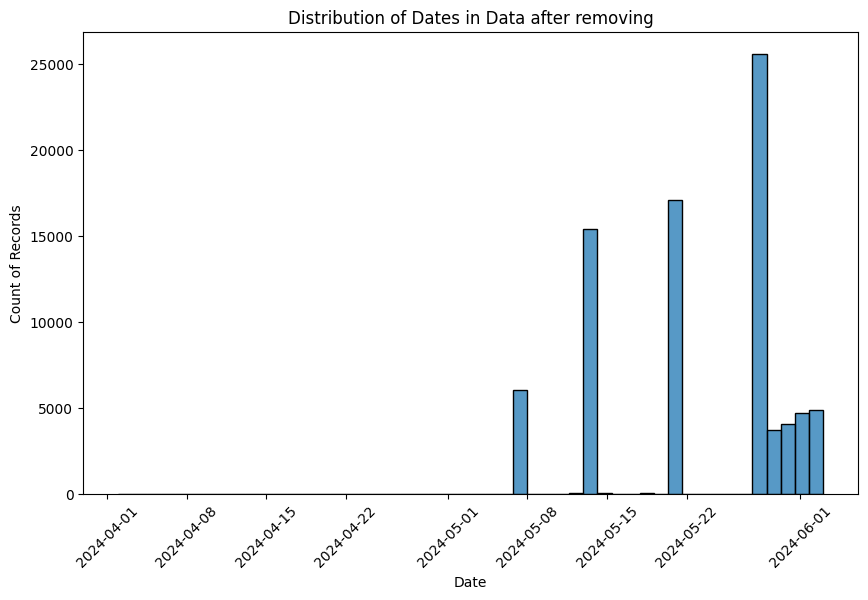

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data['gregorian_datetime'], bins=50)
plt.title('Distribution of Dates in Data after removing')
plt.xlabel('Date')
plt.ylabel('Count of Records')
plt.xticks(rotation=45) 
plt.show()

## Pie Chart of some Categoricals

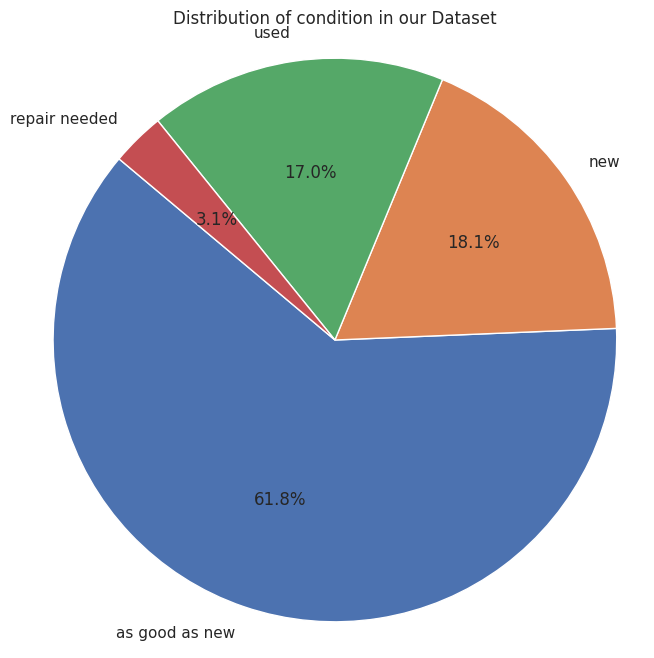

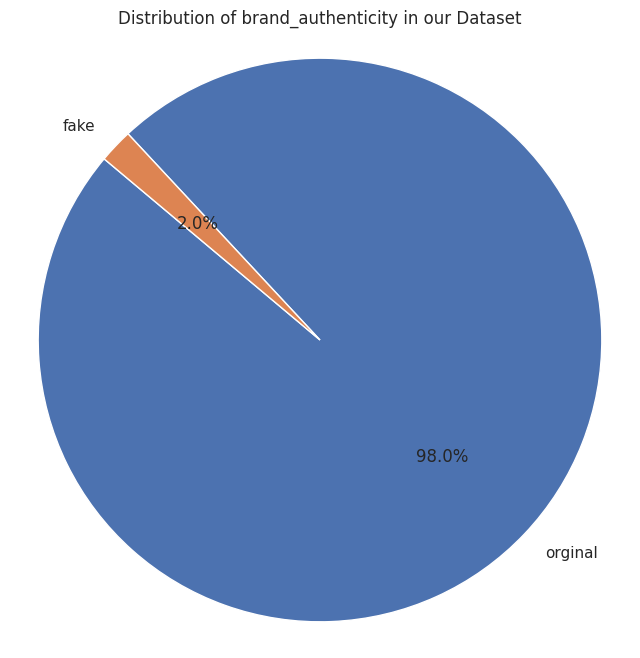

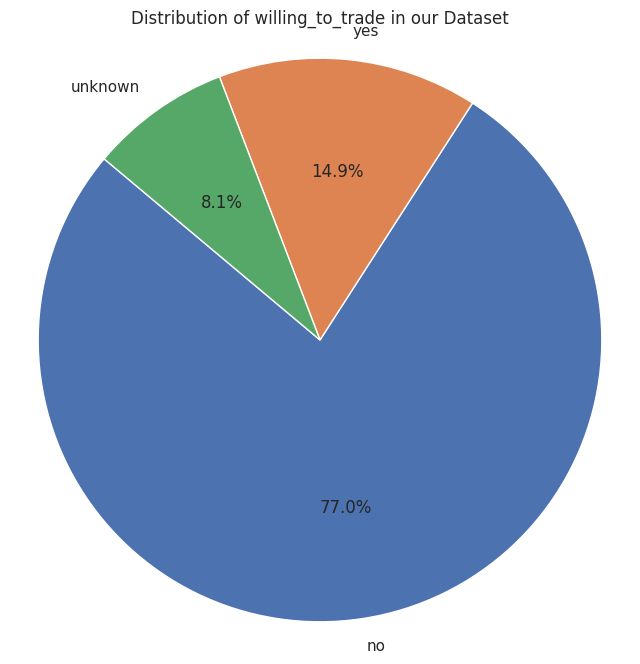

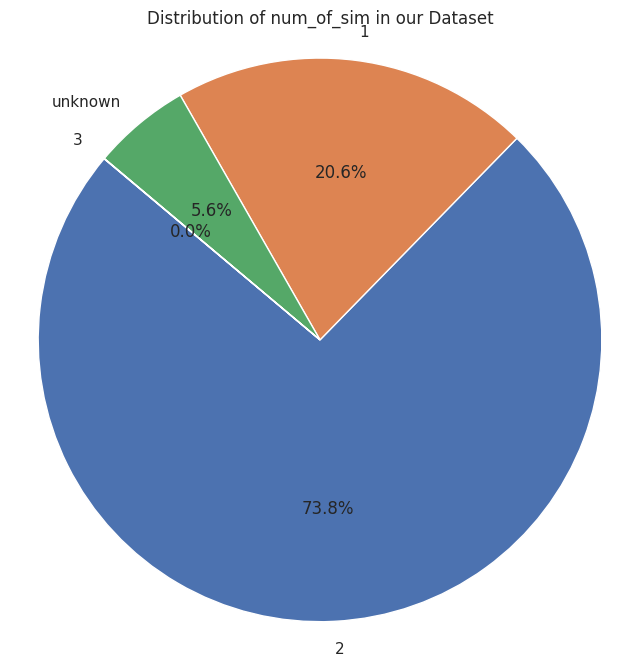

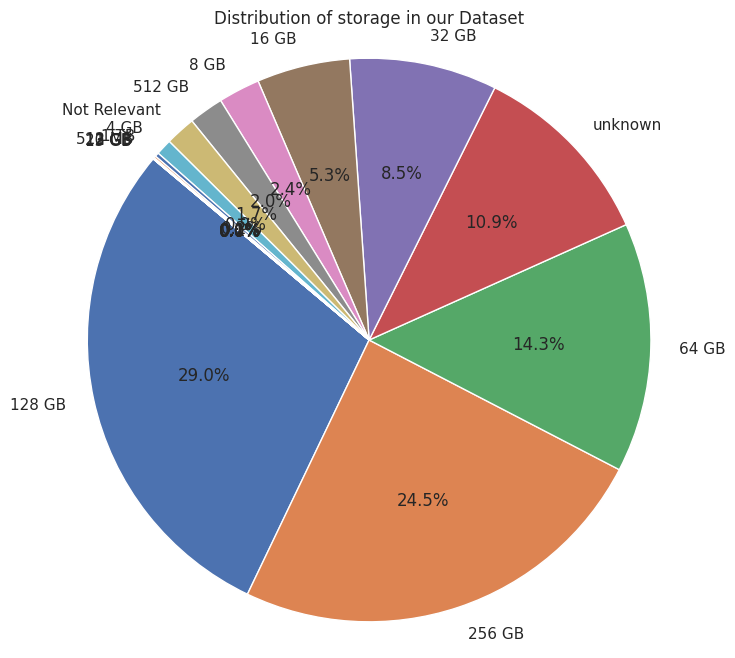

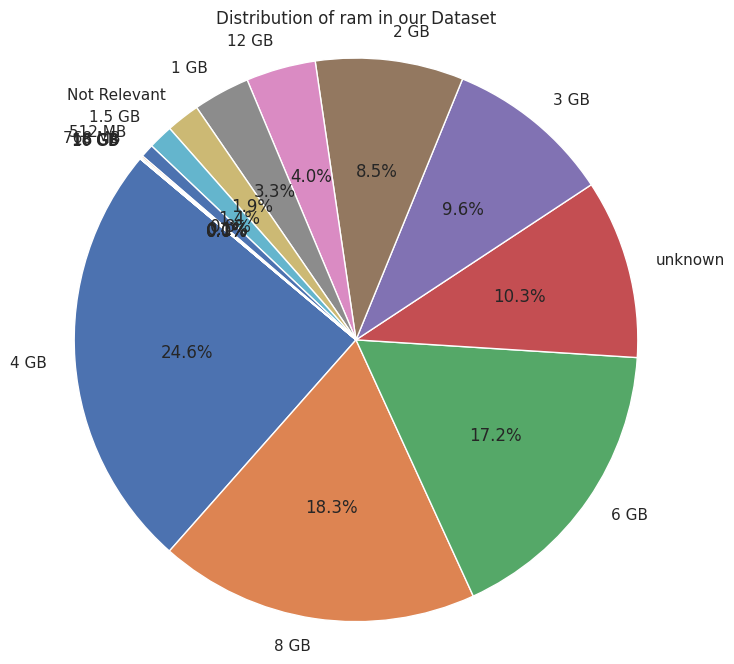

In [32]:
plot_pie_charts(data_visual, ['condition', 'brand_authenticity', 'willing_to_trade', 'num_of_sim', 'storage', 'ram'], title_suffix='in our Dataset')

## Top 30 Cities 

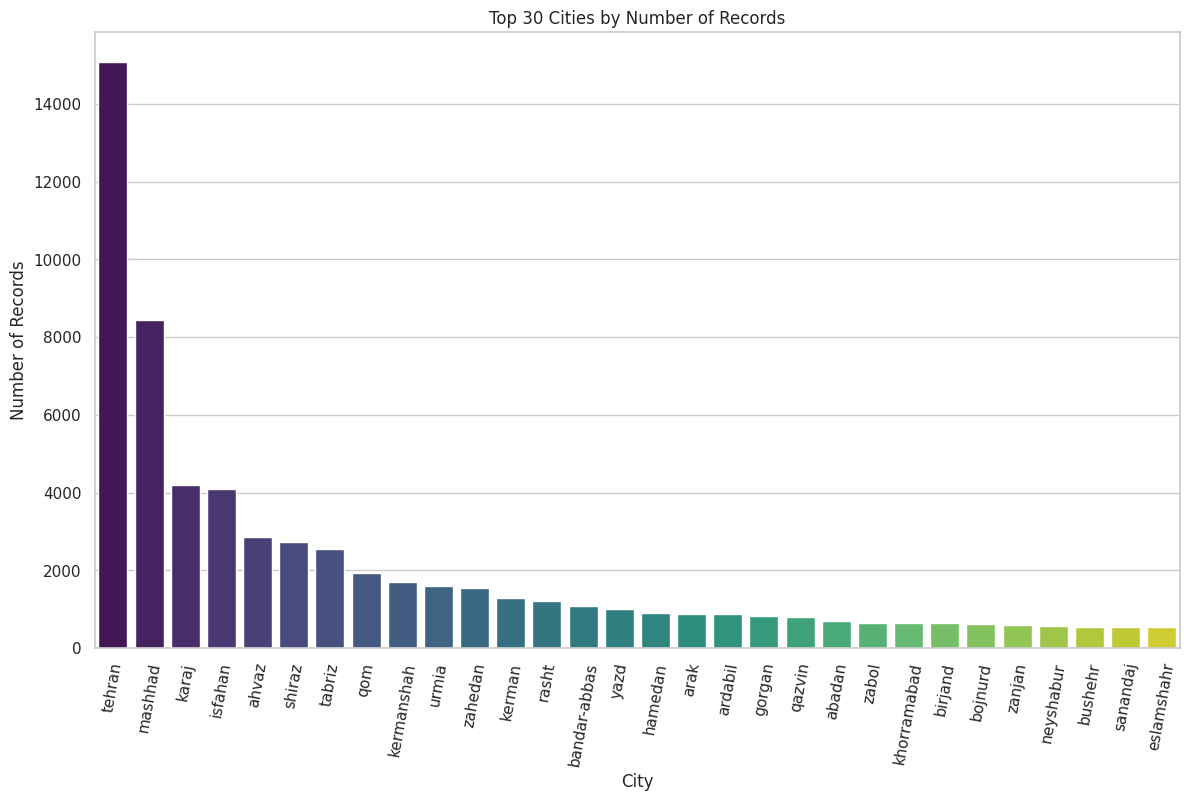

In [33]:
city_counts = data_visual['city'].value_counts().head(30) # top 30
plt.figure(figsize=(14, 8))  
sns.barplot(x=city_counts.index, y=city_counts.values, palette="viridis")
plt.title('Top 30 Cities by Number of Records')
plt.xlabel('City')
plt.ylabel('Number of Records')
plt.xticks(rotation=80) 
plt.show()

## Counting Data for storage , brand and ram

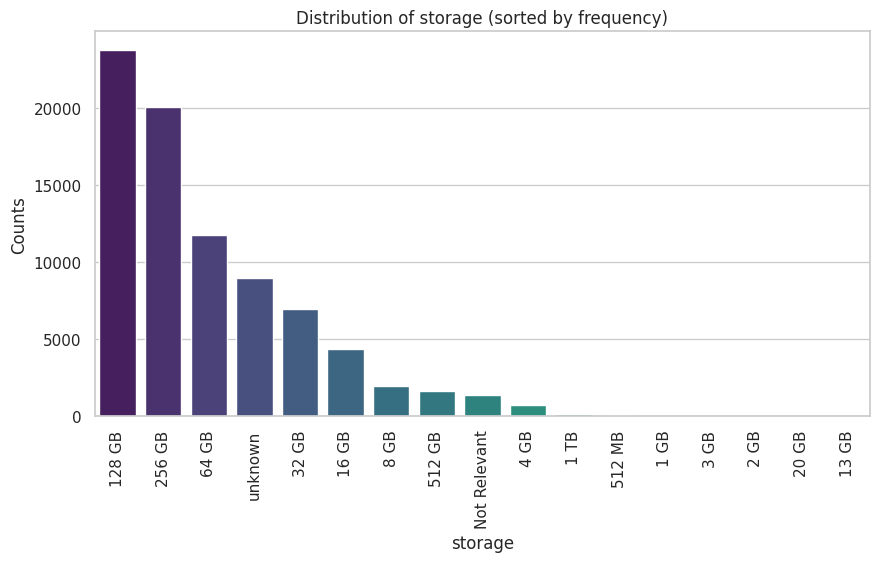

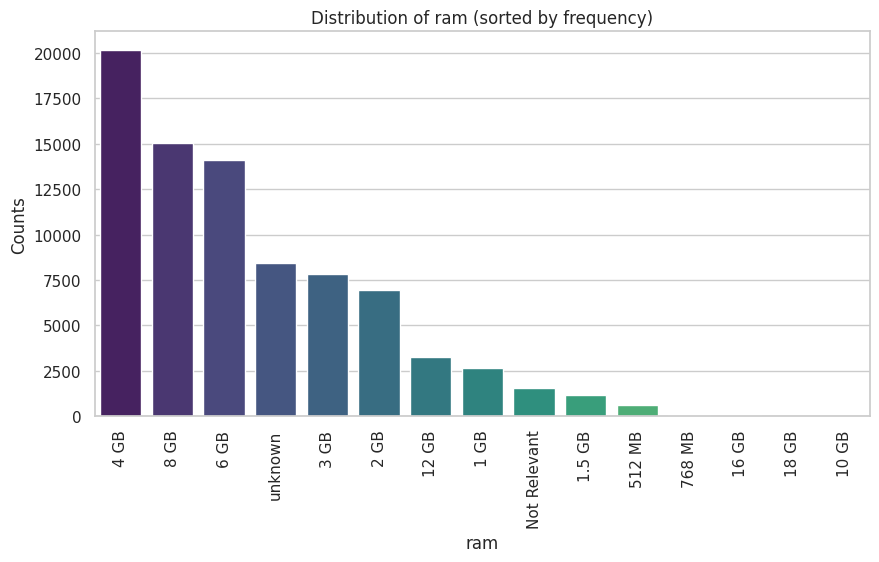

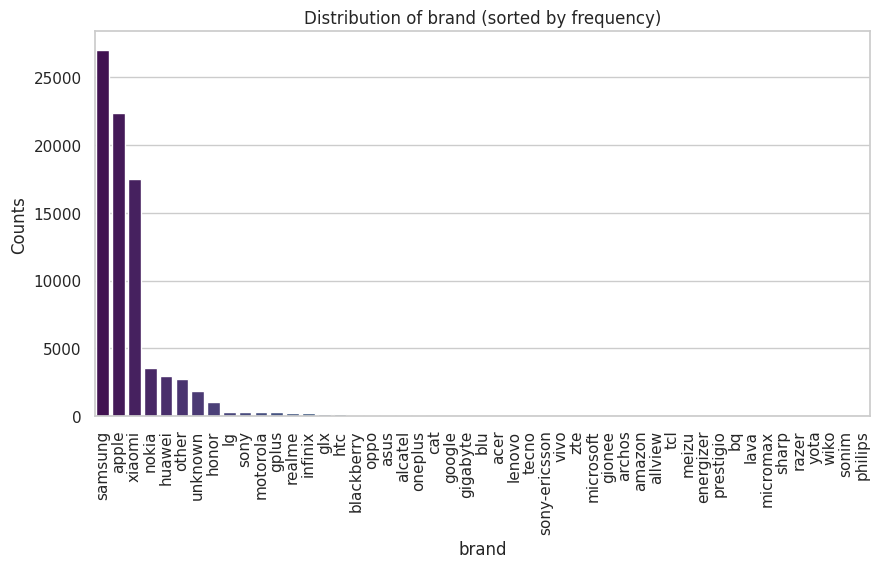

In [34]:
plot_count(data_visual , ['storage' , 'ram' , 'brand'])

## top neighborhoods

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


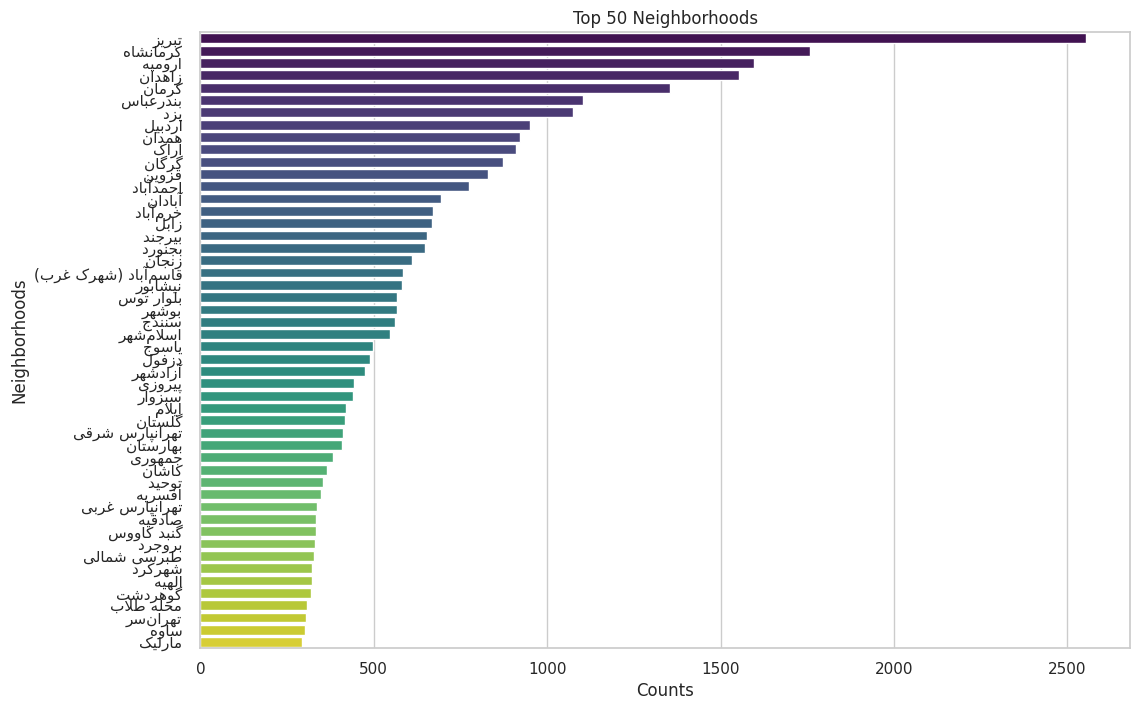

In [35]:
top_neighborhoods = data_visual['neighborhood'].value_counts().head(50) # Top 50
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in top_neighborhoods.index]

plt.figure(figsize=(12, 8))
sns.barplot(x=top_neighborhoods.values, y=reshaped_labels, palette='viridis')
plt.title('Top 50 Neighborhoods')
plt.xlabel('Counts')
plt.ylabel('Neighborhoods')
plt.show()

## Willing to trade based condition

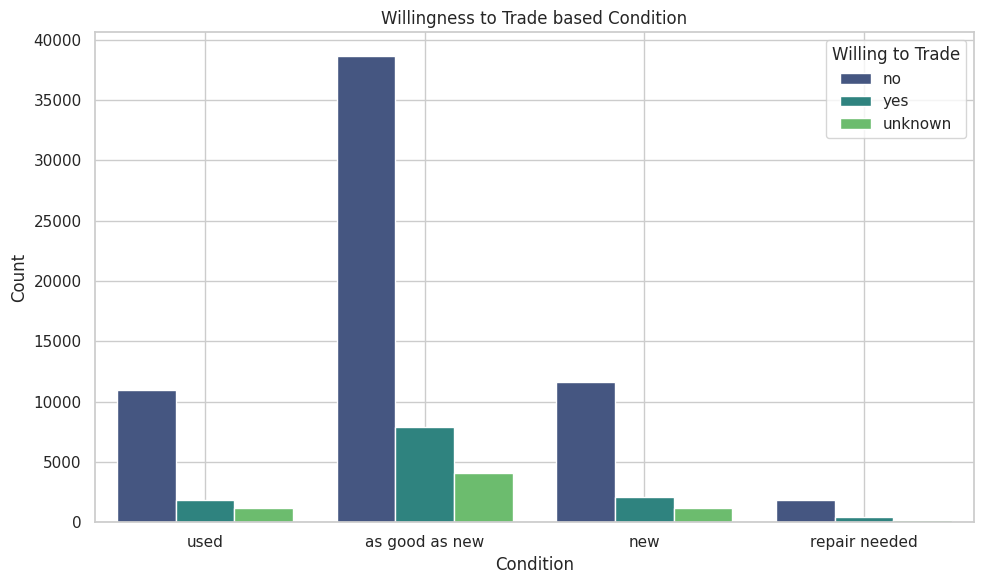

In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_visual, x='condition', hue='willing_to_trade', palette='viridis')
plt.title('Willingness to Trade based Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Willing to Trade', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Top 5 brands by frequencey of listing and conditon 

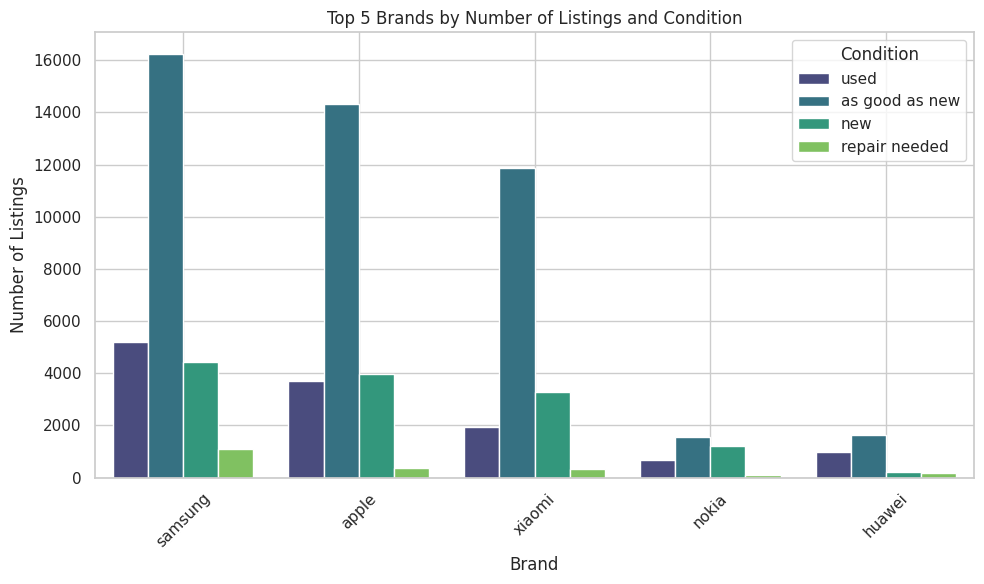

In [37]:

top_brands = data_visual['brand'].value_counts().nlargest(5).index

top_brands_data = data_visual[data_visual['brand'].isin(top_brands)]

plt.figure(figsize=(10, 6))
sns.countplot(data=top_brands_data, x='brand', hue='condition', palette='viridis', order=top_brands)
plt.title('Top 5 Brands by Number of Listings and Condition')
plt.xlabel('Brand')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.legend(title='Condition', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Top 5 neighborhoods in top 5 cities

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


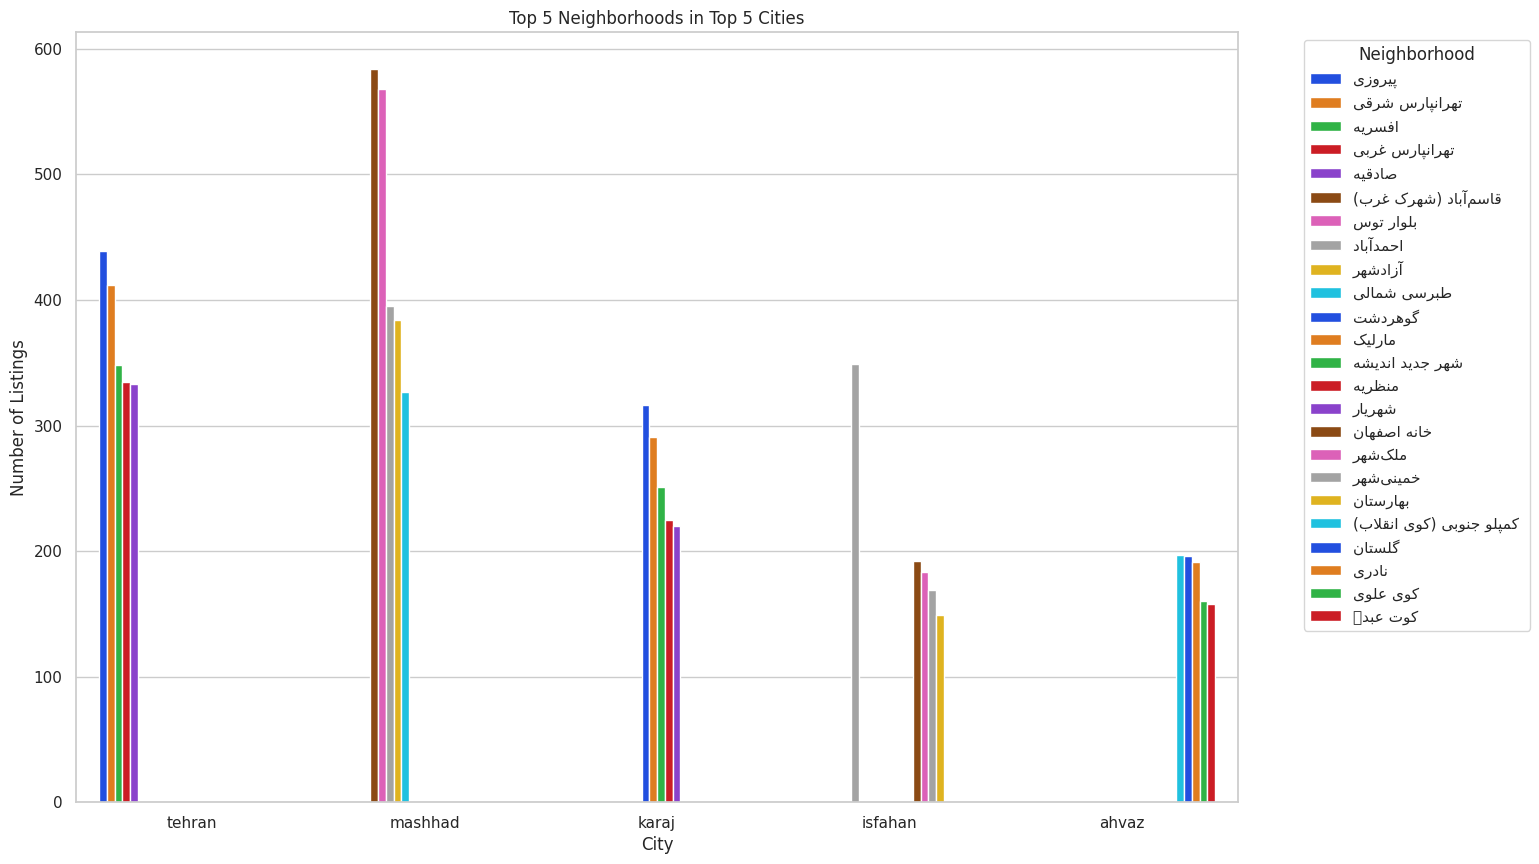

In [38]:
top_cities = data_visual['city'].value_counts().nlargest(5).index
top_cities_data = data_visual[data_visual['city'].isin(top_cities)]
top_neighborhoods_per_city = pd.DataFrame()
for city in top_cities:
    # For each city, get the top 5 neighborhoods
    top_neighborhoods = top_cities_data[top_cities_data['city'] == city]['neighborhood'].value_counts().nlargest(5)
    top_neighborhoods_df = pd.DataFrame(top_neighborhoods).reset_index()
    top_neighborhoods_df.columns = ['neighborhood', 'count']
    top_neighborhoods_df['city'] = city
    top_neighborhoods_per_city = pd.concat([top_neighborhoods_per_city, top_neighborhoods_df], ignore_index=True)

top_neighborhoods_per_city['neighborhood'] = top_neighborhoods_per_city['neighborhood'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
top_neighborhoods_per_city['city'] = top_neighborhoods_per_city['city'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))

plt.figure(figsize=(15, 10))
sns.barplot(x='city', y='count', hue='neighborhood', data=top_neighborhoods_per_city, palette='bright')
plt.title(get_display(arabic_reshaper.reshape('Top 5 Neighborhoods in Top 5 Cities')))
plt.xlabel(get_display(arabic_reshaper.reshape('City')))
plt.ylabel(get_display(arabic_reshaper.reshape('Number of Listings')))
plt.xticks(rotation=0)
plt.legend(title=get_display(arabic_reshaper.reshape('Neighborhood')), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


# getting data ready 

In [39]:
transform_to_gb(data , column='ram')
transform_to_gb(data , column='storage')
data.drop(columns=['storage' , 'ram'] ,axis=1 , inplace=True)

In [40]:
data.drop(data[data['num_of_sim'] == '3'].index , axis=0 , inplace=True)

In [41]:
separate_fa_and_eng(data, 'color')
data.drop(columns='color' , axis=1 , inplace=True)

In [42]:
data['model'] = data['model'].apply(modify_model_column)

In [43]:
data['color_fa'] = data['color_fa'].str.strip()  # Remove any leading space
data['primary_color'] = data['color_fa'].apply(extract_primary_color)

data['color_en'] = data['primary_color'].map(color_translation)

In [44]:
model_list = data['model'].tolist()  
data['clean_model'] = clean_model_names(model_list)

In [45]:
data = data[~data[['brand', 'model', 'ram_in_GB', 'storage_in_GB']].isnull().all(axis=1)]
data.shape

(81936, 22)

In [46]:
data.dropna(subset=['brand', 'ram_in_GB', 'storage_in_GB'] , inplace=True)

In [47]:
top_brands = [
    'samsung', 'apple', 'xiaomi', 'huawei', 'nokia', 'honor', 'lg', 'gplus', 'sony', 'other'
]
data['brand'] = data['brand'].apply(lambda x: x if x in top_brands else 'other')

In [48]:
data['num_of_sim'] = data['num_of_sim'].astype(int)

In [49]:
data['color_en'].fillna('unknown' , inplace=True)

/tmp/ipykernel_18/2115670702.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['color_en'].fillna('unknown' , inplace=True)


# Splitting

In [50]:
X = data[['condition' , 'brand_authenticity' , 'num_of_sim' , 'brand' , 'ram_in_GB' , 'storage_in_GB' ,'color_en', 'clean_model']]
y = data['log_price_in_millions']

In [51]:
od = OrdinalEncoder(categories=[['repair needed','used', 'as good as new' , 'new']])
X['condition_encoded'] = od.fit_transform(X[['condition']])


le = LabelEncoder()
le.fit(X['brand_authenticity'])
X['brand_authenticity_encoded'] = le.transform(X['brand_authenticity'])

one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_array = one_hot_encoder.fit_transform(X[['brand']])
encoded_df = pd.DataFrame(encoded_array, columns=one_hot_encoder.get_feature_names_out(['brand']))
encoded_df.index = X.index
X = X.join(encoded_df).drop('brand', axis=1)

/tmp/ipykernel_18/2340463509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['condition_encoded'] = od.fit_transform(X[['condition']])
/tmp/ipykernel_18/2340463509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['brand_authenticity_encoded'] = le.transform(X['brand_authenticity'])


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 , shuffle=True)

In [53]:
# For X_train
frequency_encoding = X_train['color_en'].value_counts().to_dict()
X_train['color_en'] = X_train['color_en'].map(frequency_encoding)

# For X_test
frequency_encoding_2 = X_test['color_en'].value_counts().to_dict()
X_test['color_en'] = X_test['color_en'].map(frequency_encoding_2)


X_train  , X_test


(            condition brand_authenticity  num_of_sim  ram_in_GB  \
 10471            used            orginal           2        8.0   
 37379  as good as new            orginal           2        8.0   
 72249  as good as new            orginal           2        4.0   
 44566  as good as new            orginal           2        8.0   
 52861  as good as new            orginal           2        8.0   
 ...               ...                ...         ...        ...   
 49720             new            orginal           2        8.0   
 8368   as good as new            orginal           2        8.0   
 73869  as good as new            orginal           1        2.0   
 1143   as good as new            orginal           2        6.0   
 21359  as good as new            orginal           2        6.0   
 
        storage_in_GB  color_en          clean_model  condition_encoded  \
 10471          256.0     18739          poco x3 pro                1.0   
 37379          256.0      7073 

In [54]:
# X_train
frequency_encoding_model = X_train['clean_model'].value_counts().to_dict()
X_train['clean_model'] = X_train['clean_model'].map(frequency_encoding_model)

# X_test
frequency_encoding_model_2 = X_test['clean_model'].value_counts().to_dict()
X_test['clean_model'] = X_test['clean_model'].map(frequency_encoding_model_2)

In [55]:
X_train.drop(columns=['condition' , 'brand_authenticity'] , inplace= True)
X_test.drop(columns=['condition' , 'brand_authenticity'] , inplace= True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


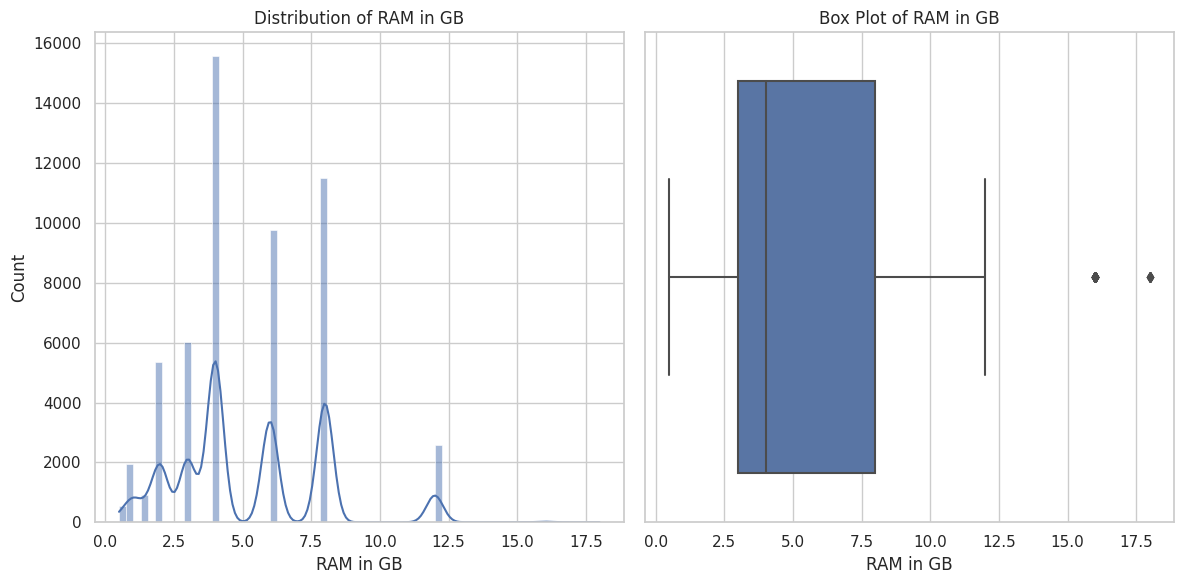

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


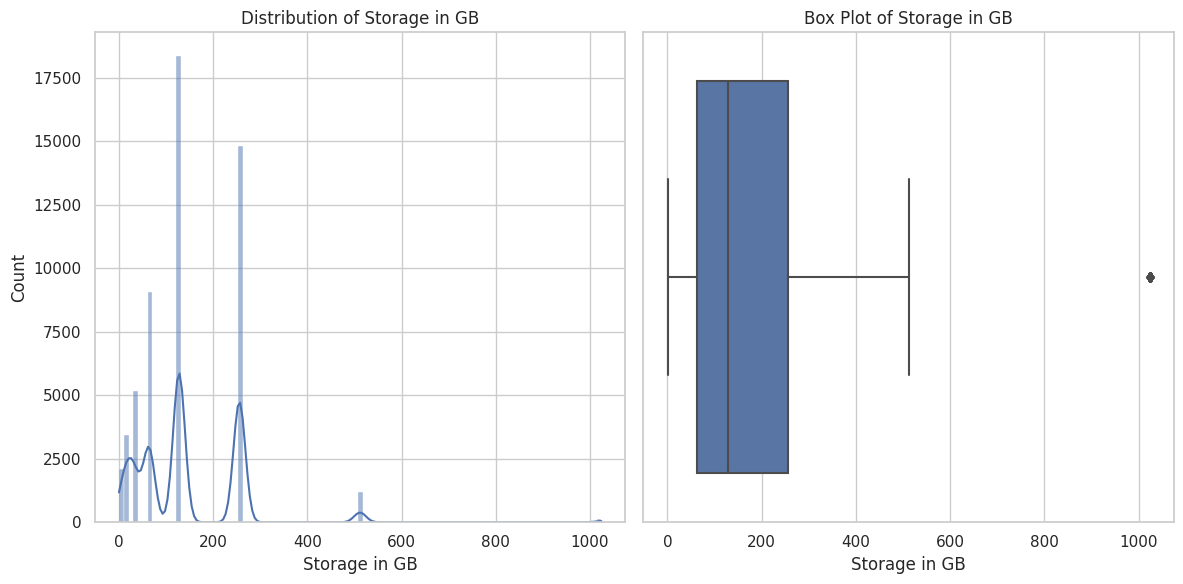

In [56]:
# Plotting the distribution of RAM
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(X_train['ram_in_GB'], kde=True)
plt.title('Distribution of RAM in GB')
plt.xlabel('RAM in GB')

plt.subplot(1, 2, 2)
sns.boxplot(x=X_train['ram_in_GB'])
plt.title('Box Plot of RAM in GB')
plt.xlabel('RAM in GB')

plt.tight_layout()
plt.show()

# Plotting the distribution of Storage
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(X_train['storage_in_GB'], kde=True)
plt.title('Distribution of Storage in GB')
plt.xlabel('Storage in GB')

plt.subplot(1, 2, 2)
sns.boxplot(x=X_train['storage_in_GB'])
plt.title('Box Plot of Storage in GB')
plt.xlabel('Storage in GB')

plt.tight_layout()
plt.show()

In [57]:
columns_to_scale = ['ram_in_GB', 'storage_in_GB']
ss = StandardScaler()
X_train[columns_to_scale] = ss.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = ss.fit_transform(X_test[columns_to_scale])

# regression model

In [58]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [59]:
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {"MSE": mse, "R2": r2}

for model_name, metrics in results.items():
    print(f"{model_name} - MSE: {metrics['MSE']}, R2: {metrics['R2']}")

Linear Regression - MSE: 0.27849584355615803, R2: 0.7607031355755494
Decision Tree - MSE: 0.454902083115083, R2: 0.6091265107601525
Random Forest - MSE: 0.29319719010206846, R2: 0.7480710399351553


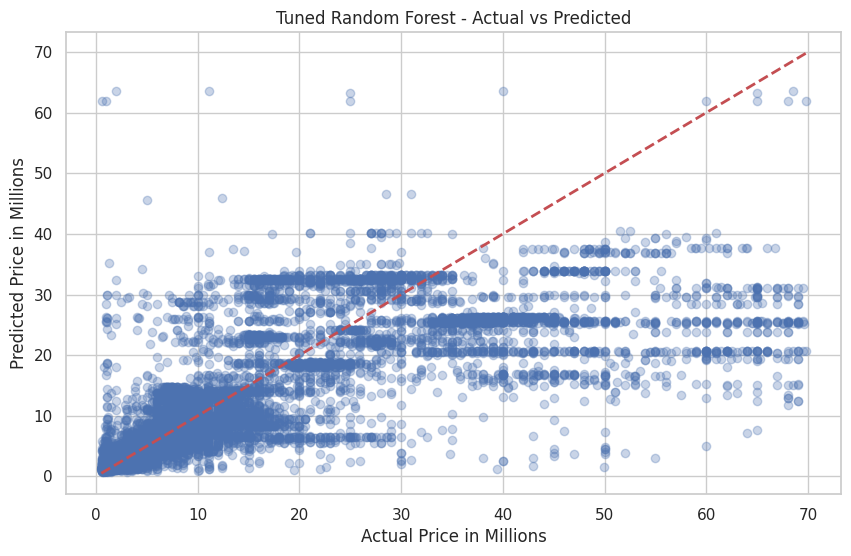

In [60]:
tuned_rf_model = RandomForestRegressor(
    bootstrap=True,
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=100
)

tuned_rf_model.fit(X_train, y_train)

y_pred_log_rf = tuned_rf_model.predict(X_test)

y_test_original = np.exp(y_test)
y_pred_original_rf = np.exp(y_pred_log_rf)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original_rf, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], '--r', linewidth=2)
plt.xlabel('Actual Price in Millions')
plt.ylabel('Predicted Price in Millions')
plt.title('Tuned Random Forest - Actual vs Predicted')
plt.show()


Gradient Boosting - MSE: 0.18948356053940857, R2: 0.8371867194925737


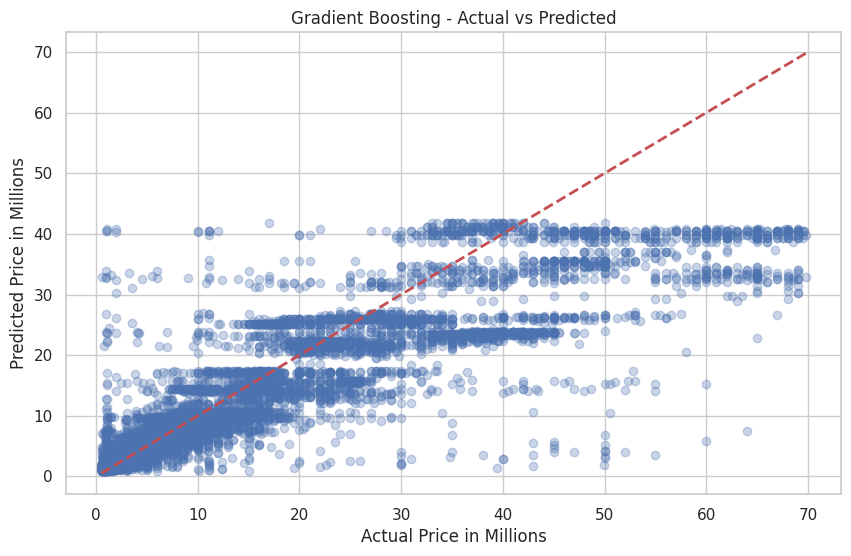

In [61]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_log_gbr = gbr.predict(X_test)

y_test_original = np.exp(y_test)
y_pred_original_gbr = np.exp(y_pred_log_gbr)

mse = mean_squared_error(y_test, y_pred_log_gbr)
r2 = r2_score(y_test, y_pred_log_gbr)
print(f"Gradient Boosting - MSE: {mse}, R2: {r2}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original_gbr, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], '--r', linewidth=2)
plt.xlabel('Actual Price in Millions')
plt.ylabel('Predicted Price in Millions')
plt.title('Gradient Boosting - Actual vs Predicted')
plt.show()


XGBoost - MSE: 0.31463132060264465, R2: 0.7296538163423081


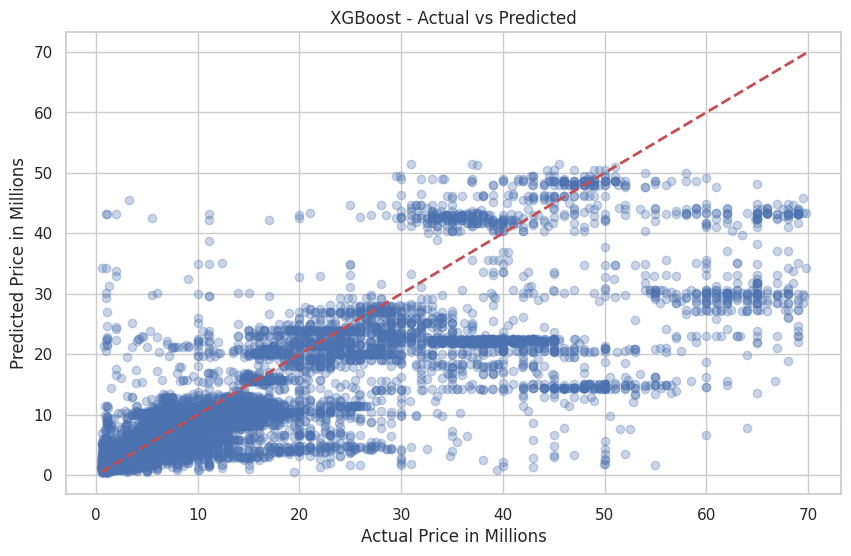

In [62]:
xgbr = XGBRegressor(objective='reg:squarederror', random_state=42)
xgbr.fit(X_train, y_train)

y_pred_log_xgbr = xgbr.predict(X_test)

y_test_original = np.exp(y_test)
y_pred_original_xgbr = np.exp(y_pred_log_xgbr)

mse = mean_squared_error(y_test, y_pred_log_xgbr)
r2 = r2_score(y_test, y_pred_log_xgbr)
print(f"XGBoost - MSE: {mse}, R2: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original_xgbr, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], '--r', linewidth=2)
plt.xlabel('Actual Price in Millions')
plt.ylabel('Predicted Price in Millions')
plt.title('XGBoost - Actual vs Predicted')
plt.show()


Voting Regressor - MSE: 0.22546395843388836, R2: 0.8062706516369437


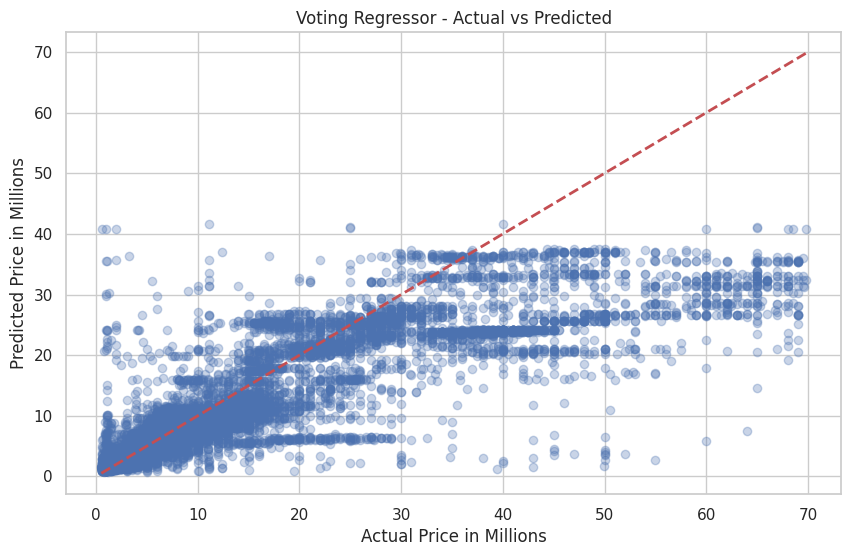

In [63]:

vr = VotingRegressor(estimators=[
    ('tuned_rf_model', tuned_rf_model), 
    ('gbr', gbr), 
    ('xgbr', xgbr)
])

vr.fit(X_train, y_train)

y_pred_log_vr = vr.predict(X_test)

y_test_original = np.exp(y_test)
y_pred_original_vr = np.exp(y_pred_log_vr)

mse = mean_squared_error(y_test, y_pred_log_vr)
r2 = r2_score(y_test, y_pred_log_vr)
print(f"Voting Regressor - MSE: {mse}, R2: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original_vr, alpha=0.3)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], '--r', linewidth=2)
plt.xlabel('Actual Price in Millions')
plt.ylabel('Predicted Price in Millions')
plt.title('Voting Regressor - Actual vs Predicted')
plt.show()